In [29]:
# Run this cell first prior to running other cells
import jax
import jax.numpy as jnp
import jax.random as jr
import jaxopt
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import os
import random
import itertools

jax.config.update("jax_enable_x64", True)

# PINN Model
ELEM_Q = 1.602e-19
BOLTZ = 1.380662e-23
EPS_0 = 8.864-12 * 1e-9
EPS_S = 11.7 * EPS_0
T = 300
KT_Q = BOLTZ * T / ELEM_Q
NI = 1e10 * 1e-21

# Define MLP
def MLP(layers: list[int] = [1, 64, 1], activation: callable = jnp.tanh):
    def init_params(key):
        def _init(key, d_in, d_out):
            w = jr.normal(key, shape=(d_in, d_out)) * jnp.sqrt(2 / (d_in + d_out))
            b = jnp.zeros((d_out,))
            return [w, b]

        keys = jr.split(key, len(layers) - 1)
        params = list(map(_init, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = inputs @ W + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = inputs @ W + b
        return outputs

    return init_params, apply


@jax.jit
def pinn(params, x, Nd, Vd_vec):
    V_contact = KT_Q * jnp.log(Nsd / NI)
    # input = jnp.hstack([jnp.atleast_1d(x), jnp.atleast_1d(Vd_vec), jnp.atleast_1d(Nd)])
    input = jnp.hstack([jnp.atleast_1d(x), jnp.atleast_1d(Vd_vec)])
    pinn_temp = apply(params, input).squeeze()
    pot = pinn_temp[0]
    log_charge = jnp.log(Nsd) + x * (1-x) * pinn_temp[1]
    return jnp.hstack([pot, log_charge])

@jax.jit
def pinn_x(params, x, Nd, Vd_vec):
    return jax.jacfwd(pinn, 1)(params, x, Nd, Vd_vec) / L

@jax.jit
def pinn_xx(params, x, Nd, Vd_vec):
    return jax.jacfwd(pinn_x, 1)(params, x, Nd, Vd_vec) / L

@jax.jit
def compute_derivatives(f, delta_X):
    # Compute the first derivative using central differences for internal points
    delta_X = delta_X * L
    df = jnp.zeros_like(f)
    df = df.at[1:-1].set((f[2:] - f[:-2]) / (2 * delta_X))
    df = df.at[0].set((f[1] - f[0]) / delta_X)  # forward difference at the first point
    df = df.at[-1].set((f[-1] - f[-2]) / delta_X)  # backward difference at the last point

    return df

# Import data and trained params, trajectory
# Need to modify the directory to where the files exist
file_name = "DD_full_data_Lsd_20.dat"
train_data = np.loadtxt(file_name)

init_params, apply = MLP([2, 100, 100, 100, 100, 2])

# Load loss trajectory
with open('loss_traj_1D_Poi_Cont_with_interface_BC.pkl', 'rb') as f:
    loaded_loss_traj = pickle.load(f)

with open('params_1D_Poi_Cont_with_interface_BC.pkl', 'rb') as f:
    loaded_params = pickle.load(f)


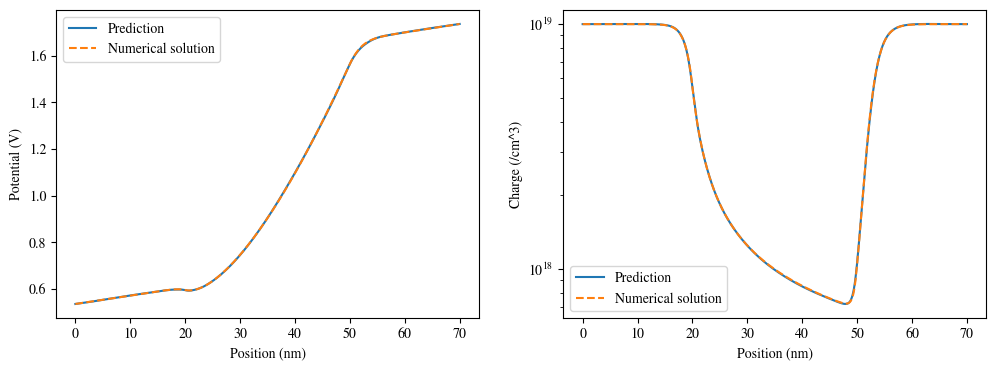

In [30]:
# Check predicted charge and potential profiles

# Define Vd to plot 
Vd = 1.2

for Lch in [30]:
    L = Lch + 2 * Lsd
    for Nsd  in [1e-2]: 
        for Nch in [1e-4]:
            interface_idx = round(Lsd / (dx * L))
                                       
            Vd_input = jnp.linspace(0, Vd, 501)
            
            Nd = Nsd * np.ones((501, 1))                
            Nd[interface_idx+1:501 - interface_idx] = Nch # Nch
            
            Nd = jnp.array(  ( np.log(Nd) - np.log(Nsd_min) )  / (np.log(Nsd_max) - np.log(Nsd_min))  )
        
            # Get training data 
            curr_data = train_data[(train_data[:, 0] == Nsd * 1e21) & (train_data[:, 1] == Nch * 1e21) & \
                    (train_data[:, 2] == Lch ) & (train_data[:, 3] == Vd)]
            
            test_pot = curr_data[0, 5:506]
            test_charge = curr_data[0, 506:1008] * 1e-27
            
            pred = jax.vmap(pinn, in_axes=(None, 0, 0, 0))(loaded_params, x, Nd, Vd_input)

            _, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
            ax0.plot(x * L, pred[:, 0], label="Prediction")
            ax0.plot(x * L, test_pot, "--", label="Numerical solution")
            ax0.set(xlabel='Position (nm)', ylabel='Potential (V)')
            ax0.legend()
                         
            ax1.semilogy(x * L, np.exp(pred[:, 1]) * 1e21, label="Prediction")
            ax1.plot(x * L, test_charge * 1e21, "--", label="Numerical solution")
            ax1.set(xlabel='Position (nm)', ylabel='Charge (/cm^3)')
            ax1.legend()
            
                

0.0020312506845879446

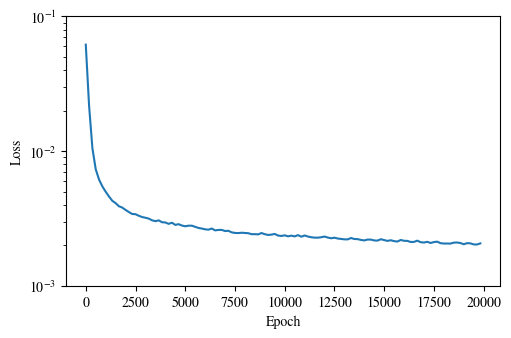

In [31]:
# Plot loss trajectory
_, ax0 = plt.subplots(1, 1)
it = np.array(range(120)) * 20000 / 120 
ax0.semilogy(it, loaded_loss_traj)
ax0.set(xlabel='Epoch', ylabel='Loss')
ax0.set_ylim(1e-3, 1e-1)
plt.show
np.array(loaded_loss_traj).min()

In [32]:
# Calculate L2 loss across different datasets 
# Initialize parameters
ELEM_Q = 1.602e-19
BOLTZ = 1.380662e-23
EPS_0 = 8.864-12 * 1e-9
EPS_S = 11.7 * EPS_0
T = 300
KT_Q = BOLTZ * T / ELEM_Q
NI = 1e10 * 1e-21
Lsd = 20
L2_loss = np.zeros((2))
Linf_loss = np.zeros((2))
Linf_loss_temp = np.zeros((2))

# Training data 
Vd_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2] # Full list
Vd_train = [0, 0.2, 0.4, 0.6, 0.8, 1.0] # Training data
Vd_inter = [0.05, 0.1, 0.15, 0.25, 0.3, 0.35, 0.45, 0.5, 0.55, 0.65, 0.7, 0.75, 0.85, 0.9, 0.95] # Interpolation data
Vd_extra = [1.05, 1.1, 1.15, 1.2] # Extrapolation data

# Compute losses
Id = []
Id_pred = []
Vd_testing_sample = Vd_list # Modify this to (Vd_list or Vd_train or Vd_inter or Vd_extra)
for Lch in [30]:
    L = Lch + 2 * Lsd
    for Nsd  in [1e-2]: 
        for Nch in [1e-4]:
            for Vd in Vd_testing_sample:
                interface_idx = round(Lsd / (dx * L))
                
                Vd_input = jnp.linspace(0, Vd, 501)


                Nd = Nsd * np.ones((501, 1))                
                Nd[interface_idx+1:501 - interface_idx] = Nch # Nch
                
                Nd = jnp.array(  ( np.log(Nd) - np.log(Nsd_min) )  / (np.log(Nsd_max) - np.log(Nsd_min))  )
            
                # Get training data 
                curr_data = train_data[(train_data[:, 0] == Nsd * 1e21) & (train_data[:, 1] == Nch * 1e21) & \
                        (train_data[:, 2] == Lch ) & (train_data[:, 3] == Vd)]
                
                test_pot = curr_data[0, 5:506]
                test_charge = curr_data[0, 506:1008] * 1e-27
                
                pred = jax.vmap(pinn, in_axes=(None, 0, 0, 0))(loaded_params, x, Nd, Vd_input)        

                L2_loss[0] += (((pred[:, 0] - test_pot)**2).sum() / ((test_pot)**2).sum())**0.5 
                L2_loss[1] += (((np.exp(pred[:, 1]) - test_charge)**2).sum() / ((test_charge)**2).sum())**0.5 
                
                Linf_loss_temp[0] = (np.abs(pred[:, 0] - test_pot)).max()
                Linf_loss_temp[1] = (np.abs(np.exp(pred[:, 1]) - test_charge)).max() / Nsd_max
                
                Id.append(curr_data[0, 4])

                idx = -95 # Compute average derivative from idx to end
                diff_pred_pot = compute_derivatives(pred[idx:, 0], dx * 1e-9).mean()
                diff_pred_charge = compute_derivatives(jnp.exp(pred[idx:, 1])*1e27, dx * 1e-9).mean()
                Id_pred_temp = ELEM_Q * 1417 * ((1e27*np.exp(pred[idx:, 1])).mean() * diff_pred_pot  - KT_Q * diff_pred_charge) * 1e-8
                
                Id_pred.append(Id_pred_temp)

                if Linf_loss_temp[0] > Linf_loss[0]:
                    Linf_loss[0] = Linf_loss_temp[0]

                if Linf_loss_temp[1] > Linf_loss[1]:
                    Linf_loss[1] = Linf_loss_temp[1]
                    
L2_loss /= len(Vd_testing_sample)

print(f"pot L2 loss : {L2_loss[0]:.5e}, pot Linf loss : {Linf_loss[0]:.5e}, charge L2 loss : {L2_loss[1]:.5e}, charge Linf loss : {Linf_loss[1]:.5e}")



pot L2 loss : 2.31785e-04, pot Linf loss : 3.37963e-03, charge L2 loss : 9.23512e-04, charge Linf loss : 7.76041e-03


0.9247110018333001

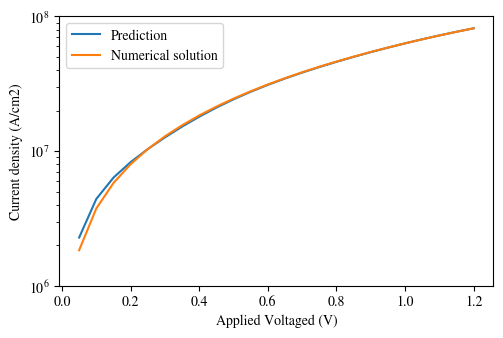

In [33]:
# Plot current and calculate L2_loss (Run previous cell with Vd_testing_sample = Vd_list, then run this cell)
_, ax0 = plt.subplots(1, 1)
it = np.array(range(120)) * 20000 / 120 
ax0.semilogy(Vd_list[1:], Id_pred[1:], label="Prediction")
ax0.semilogy(Vd_list[1:], Id[1:], label="Numerical solution")
ax0.set(xlabel='Applied Voltaged (V)', ylabel='Current density (A/cm2)')
ax0.set_ylim(1e6, 1e8)
ax0.legend()

L2_loss=((((np.array(Id_pred[1:])- np.array(Id[1:]))**2).sum() / (np.array(Id[1:]))**2).sum())**0.5
L2_loss